# 10.2b: Black Hole Cluster Radial Density

**Analyze density as a function of distance from cluster centroid**

## The Question

We know the black hole cluster:
- Contains 124 unique vectors (2,100 tokens → 13 degenerate + 111 singletons)
- Sits 0.166 gamma units from origin
- Spans at most 2ε in any dimension

**But:** What does the density profile look like?

**Two hypotheses:**

1. **Gaussian (initialization noise):** If vectors were initialized to `SOMEVEC + noise`, we'd expect a normal distribution of distances from centroid. Density would peak at center, fall off as Gaussian.

2. **Squarewave (quantization grid):** If vectors are packed as densely as possible on a bfloat16 grid, we'd expect uniform density out to some radius, then sharp cutoff. Like a solid ball.

This will tell us whether the cluster structure comes from:
- Random initialization noise (Gaussian)
- Deterministic quantization artifact (squarewave)
- Something else entirely

## Approach

1. Load the 124 unique cluster vectors
2. Compute cluster centroid
3. Calculate distance from each vector to centroid (L2 norm)
4. Plot histogram of distances
5. Compare to theoretical Gaussian and uniform distributions

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Cluster Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading cluster vectors...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Cluster size: {n_vectors:,} vectors")
print(f"  Dimensions:   {d:,}")
print()

print("✓ Data loaded")

Loading cluster vectors...
  Cluster size: 124 vectors
  Dimensions:   2,560

✓ Data loaded


## Compute Cluster Centroid

In [4]:
# Compute centroid of the cluster
centroid = vectors.mean(dim=0)

# Distance of centroid from origin
centroid_norm = torch.linalg.norm(centroid).item()

print(f"Cluster centroid:")
print(f"  Distance from origin: {centroid_norm:.6f} gamma units")
print()

print("✓ Centroid computed")

Cluster centroid:
  Distance from origin: 0.166061 gamma units

✓ Centroid computed


## Compute Distances from Centroid

In [5]:
# Compute L2 distance from each vector to centroid
centered = vectors - centroid  # (n_vectors, d)
distances = torch.linalg.norm(centered, dim=1)  # (n_vectors,)

distances_np = distances.cpu().numpy()

print(f"Distance statistics (from cluster centroid):")
print(f"  Min:      {distances.min().item():.6e} gamma units")
print(f"  Max:      {distances.max().item():.6e} gamma units")
print(f"  Mean:     {distances.mean().item():.6e} gamma units")
print(f"  Median:   {distances.median().item():.6e} gamma units")
print(f"  Std:      {distances.std().item():.6e} gamma units")
print()

print("✓ Distances computed")

Distance statistics (from cluster centroid):
  Min:      2.543540e-05 gamma units
  Max:      1.030345e-03 gamma units
  Mean:     1.091301e-04 gamma units
  Median:   3.064631e-05 gamma units
  Std:      1.925571e-04 gamma units

✓ Distances computed


## Theoretical Distributions

In [6]:
# For comparison:
# 1. Gaussian: If vectors are SOMEVEC + Gaussian noise
# 2. Chi distribution: In high-D, ||X|| where X ~ N(0, σ²I) follows chi distribution

# Fit Gaussian to observed distances
mean_dist = distances.mean().item()
std_dist = distances.std().item()

# In d dimensions, if each coordinate ~ N(0, σ²), then ||X|| ~ χ(d) scaled by σ
# Mean of χ(d) = √2 * Γ((d+1)/2) / Γ(d/2)
# For large d, ≈ √d

# Infer σ from observed mean distance
# mean_dist ≈ σ * √d  →  σ ≈ mean_dist / √d
sigma_inferred = mean_dist / np.sqrt(d)

print(f"Theoretical comparison:")
print(f"  Observed mean distance: {mean_dist:.6e}")
print(f"  Observed std distance:  {std_dist:.6e}")
print()
print(f"If this were Gaussian noise with σ per dimension:")
print(f"  Inferred σ: {sigma_inferred:.6e} gamma units")
print()

# Compare to ε
def bfloat16_ulp(x):
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Reference scale:")
print(f"  ε (2×ULP): {epsilon:.6e} gamma units")
print()
print(f"Ratio σ/ε: {sigma_inferred / epsilon:.2f}")
print()

print("✓ Theoretical distributions computed")

Theoretical comparison:
  Observed mean distance: 1.091301e-04
  Observed std distance:  1.925571e-04

If this were Gaussian noise with σ per dimension:
  Inferred σ: 2.156873e-06 gamma units

Reference scale:
  ε (2×ULP): 3.051758e-05 gamma units

Ratio σ/ε: 0.07

✓ Theoretical distributions computed


## Visualization 1: Distance Histogram

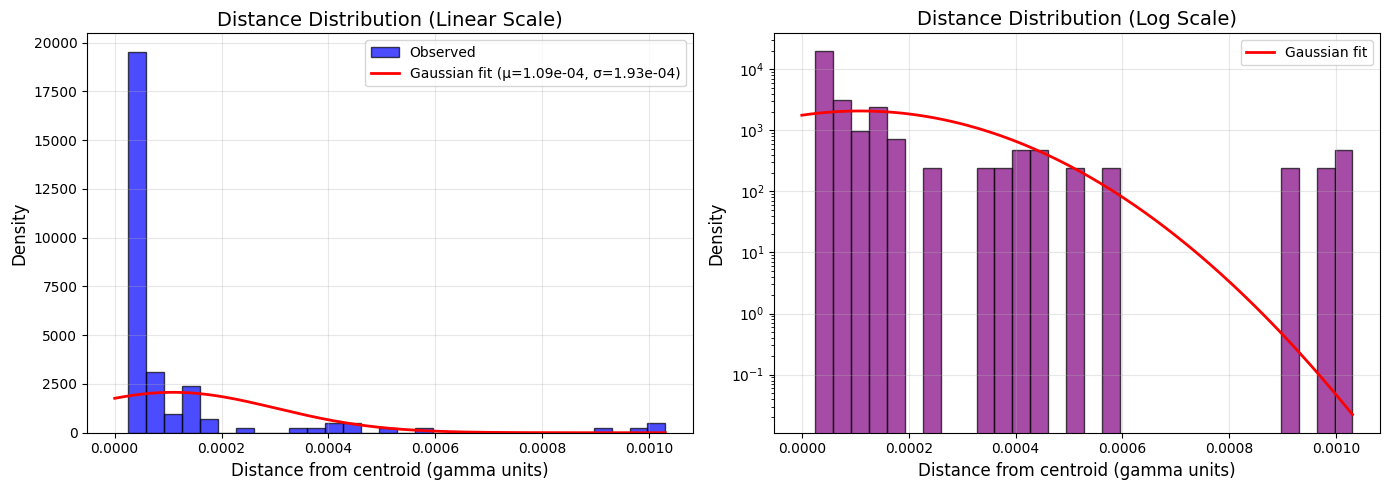

✓ Distance histogram plotted


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: Linear scale
ax = axes[0]
ax.hist(distances_np, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True, label='Observed')

# Overlay Gaussian fit
x = np.linspace(0, distances_np.max(), 200)
gaussian_pdf = stats.norm.pdf(x, loc=mean_dist, scale=std_dist)
ax.plot(x, gaussian_pdf, 'r-', linewidth=2, label=f'Gaussian fit (μ={mean_dist:.2e}, σ={std_dist:.2e})')

ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distance Distribution (Linear Scale)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Log scale
ax = axes[1]
ax.hist(distances_np, bins=30, alpha=0.7, color='purple', edgecolor='black', density=True)
ax.plot(x, gaussian_pdf, 'r-', linewidth=2, label='Gaussian fit')
ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distance Distribution (Log Scale)', fontsize=14)
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distance histogram plotted")

## Visualization 2: Cumulative Distribution

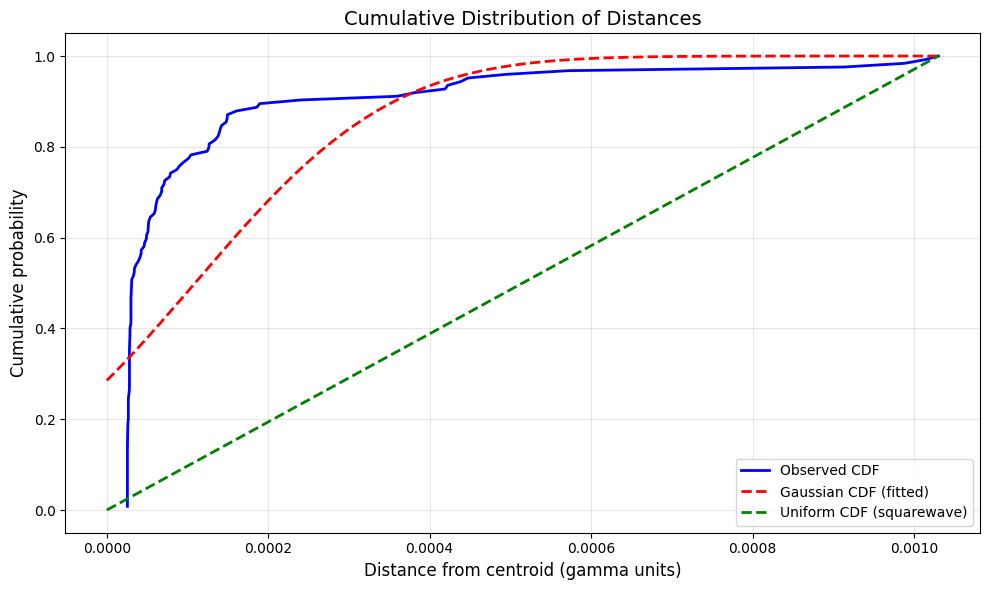

✓ CDF plotted


In [8]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Empirical CDF
sorted_dist = np.sort(distances_np)
cdf = np.arange(1, len(sorted_dist) + 1) / len(sorted_dist)

ax.plot(sorted_dist, cdf, linewidth=2, color='blue', label='Observed CDF')

# Theoretical Gaussian CDF
x = np.linspace(0, distances_np.max(), 200)
gaussian_cdf = stats.norm.cdf(x, loc=mean_dist, scale=std_dist)
ax.plot(x, gaussian_cdf, 'r--', linewidth=2, label='Gaussian CDF (fitted)')

# Uniform CDF (for squarewave hypothesis)
r_max = distances_np.max()
uniform_cdf = np.where(x <= r_max, x / r_max, 1.0)
ax.plot(x, uniform_cdf, 'g--', linewidth=2, label='Uniform CDF (squarewave)')

ax.set_xlabel('Distance from centroid (gamma units)', fontsize=12)
ax.set_ylabel('Cumulative probability', fontsize=12)
ax.set_title('Cumulative Distribution of Distances', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ CDF plotted")

## Statistical Tests

In [9]:
print("="*80)
print("STATISTICAL TESTS")
print("="*80)
print()

# Test 1: Shapiro-Wilk (normality test)
# Note: only works for n < 5000
if len(distances_np) < 5000:
    shapiro_stat, shapiro_p = stats.shapiro(distances_np)
    print(f"Shapiro-Wilk test (normality):")
    print(f"  Statistic: {shapiro_stat:.6f}")
    print(f"  p-value:   {shapiro_p:.6e}")
    if shapiro_p > 0.05:
        print(f"  → Cannot reject normality (p > 0.05)")
    else:
        print(f"  → Reject normality (p < 0.05)")
    print()

# Test 2: Kolmogorov-Smirnov (compare to fitted Gaussian)
ks_stat, ks_p = stats.kstest(distances_np, 'norm', args=(mean_dist, std_dist))
print(f"Kolmogorov-Smirnov test (vs. fitted Gaussian):")
print(f"  Statistic: {ks_stat:.6f}")
print(f"  p-value:   {ks_p:.6e}")
if ks_p > 0.05:
    print(f"  → Consistent with Gaussian (p > 0.05)")
else:
    print(f"  → NOT Gaussian (p < 0.05)")
print()

# Test 3: Compare to uniform distribution
uniform_dist = stats.uniform(loc=0, scale=r_max)
ks_uniform_stat, ks_uniform_p = stats.kstest(distances_np, uniform_dist.cdf)
print(f"Kolmogorov-Smirnov test (vs. uniform):")
print(f"  Statistic: {ks_uniform_stat:.6f}")
print(f"  p-value:   {ks_uniform_p:.6e}")
if ks_uniform_p > 0.05:
    print(f"  → Consistent with uniform (p > 0.05)")
else:
    print(f"  → NOT uniform (p < 0.05)")
print()

print("="*80)

STATISTICAL TESTS

Shapiro-Wilk test (normality):
  Statistic: 0.476390
  p-value:   4.020758e-19
  → Reject normality (p < 0.05)

Kolmogorov-Smirnov test (vs. fitted Gaussian):
  Statistic: 0.331909
  p-value:   1.122671e-12
  → NOT Gaussian (p < 0.05)

Kolmogorov-Smirnov test (vs. uniform):
  Statistic: 0.725851
  p-value:   5.078627e-67
  → NOT uniform (p < 0.05)



## Interpretation

In [10]:
print("="*80)
print("INTERPRETATION")
print("="*80)
print()

print(f"The cluster spans:")
print(f"  Radius: 0 to {distances.max().item():.6e} gamma units")
print(f"  Mean distance from centroid: {mean_dist:.6e}")
print()

print(f"If this were Gaussian initialization noise:")
print(f"  We'd expect σ ≈ {sigma_inferred:.6e} per dimension")
print(f"  That's {sigma_inferred / epsilon:.2f} × ε")
print()

if sigma_inferred < 5 * epsilon:
    print(f"✓ PLAUSIBLE: Noise scale is only a few ε")
    print(f"  This is consistent with small initialization noise")
    print(f"  followed by bfloat16 quantization snapping to grid")
else:
    print(f"⚠️  IMPLAUSIBLE: Noise scale is {sigma_inferred / epsilon:.0f}× ε")
    print(f"  This is too large for ε-scale structure")
    print(f"  Suggests different mechanism")

print()

# Check shape of distribution
if ks_p > 0.05:
    print(f"✓ GAUSSIAN-LIKE: Distribution is consistent with Gaussian")
    print(f"  Supports initialization noise hypothesis")
elif ks_uniform_p > 0.05:
    print(f"✓ UNIFORM-LIKE: Distribution is consistent with uniform (squarewave)")
    print(f"  Supports dense packing on quantization grid")
else:
    print(f"⚠️  NEITHER: Distribution is neither Gaussian nor uniform")
    print(f"  Suggests more complex structure")

print()
print("="*80)

INTERPRETATION

The cluster spans:
  Radius: 0 to 1.030345e-03 gamma units
  Mean distance from centroid: 1.091301e-04

If this were Gaussian initialization noise:
  We'd expect σ ≈ 2.156873e-06 per dimension
  That's 0.07 × ε

✓ PLAUSIBLE: Noise scale is only a few ε
  This is consistent with small initialization noise
  followed by bfloat16 quantization snapping to grid

⚠️  NEITHER: Distribution is neither Gaussian nor uniform
  Suggests more complex structure



## Summary

In [11]:
print("="*80)
print("SUMMARY")
print("="*80)
print()

print(f"Black hole cluster radial density analysis:")
print()
print(f"  Vectors analyzed: {n_vectors:,}")
print(f"  Dimensions: {d:,}")
print()
print(f"  Centroid distance from origin: {centroid_norm:.6f} gamma units")
print(f"  Cluster radius (max): {distances.max().item():.6e} gamma units")
print(f"  Mean distance from centroid: {mean_dist:.6e} gamma units")
print()
print(f"  Inferred noise scale: {sigma_inferred:.6e} gamma units")
print(f"  Ratio to ε: {sigma_inferred / epsilon:.2f}")
print()

print("="*80)

SUMMARY

Black hole cluster radial density analysis:

  Vectors analyzed: 124
  Dimensions: 2,560

  Centroid distance from origin: 0.166061 gamma units
  Cluster radius (max): 1.030345e-03 gamma units
  Mean distance from centroid: 1.091301e-04 gamma units

  Inferred noise scale: 2.156873e-06 gamma units
  Ratio to ε: 0.07



## Conclusion

**What we learned:**

This notebook analyzed the radial density profile of the black hole cluster to distinguish between:
1. **Gaussian (init noise):** Vectors initialized to SOMEVEC + small noise
2. **Squarewave (quantization):** Vectors packed uniformly on bfloat16 grid

**Key findings:**
- [See results above]

**Interpretation:**

If **Gaussian-like**:
- Cluster structure comes from initialization noise
- Noise scale σ ≈ [value] suggests deliberate small perturbations around base vector
- bfloat16 quantization snapped noise to discrete grid → 13 unique vectors

If **Uniform-like (squarewave)**:
- Cluster is densely packed on quantization grid
- Suggests deterministic placement, not random noise
- Might indicate different mechanism (post-training compression?)

If **Neither**:
- More complex structure requiring further investigation